# Debugging AutoML Pipeline (Notebook Version) - Clean Start

# Setup import path and working directory

In [1]:
import os
print("Current working directory:", os.getcwd())
import sys
os.chdir("..")  # move up to project root
sys.path.append(os.path.abspath("."))
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from automl.config import load_config
from automl.pipeline import run_pipeline
from automl.evaluator import evaluate_classification_model, plot_confusion



Current working directory: c:\Machine Learning Projects\automl-system\notebooks


c:\Machine Learning Projects\automl-system\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load configuration


In [2]:
config = load_config("config.yaml")

# Run full pipeline


In [3]:
results = run_pipeline(
    data_path=config['data_path'],
    target_col=config['target_col'],
    k_features=config['k_features'],
    scoring=config['scoring'],
    cv=config['cv'],
    do_tuning=config.get('do_tuning', False)
)

c:\Machine Learning Projects\automl-system\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Machine Learning Projects\automl-system\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Machine Learning Projects\automl-system\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Machine Learning Projects\automl-system\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:32] WARNING: C:\actions-runner\_work\xgboost\xgbo


Model Performance:
                    mean_score  std_score
LogisticRegression    0.585640   0.022491
XGBoost               0.554560   0.013929
RandomForest          0.532727   0.027043

 Best Model: LogisticRegression


# Load and split data


In [4]:
raw_df = pd.read_csv(config['data_path'])
X = raw_df.drop(columns=config['target_col'])
y = raw_df[config['target_col']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess and select features


In [5]:
preprocessor = results['preprocessor']
selector = results['feature_selector']

X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)
y_train_proc = preprocessor.transform_target(y_train)
y_test_proc = preprocessor.transform_target(y_test)

X_train_sel = selector.transform(X_train_proc)
X_test_sel = selector.transform(X_test_proc)

# Get best model


In [6]:
model = results['best_model']

# Evaluate model on test set



 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


 Evaluation Metrics:
accuracy: 0.7913
f1_score: 0.5764
precision: 0.6250
recall: 0.5348
roc_auc: 0.8385


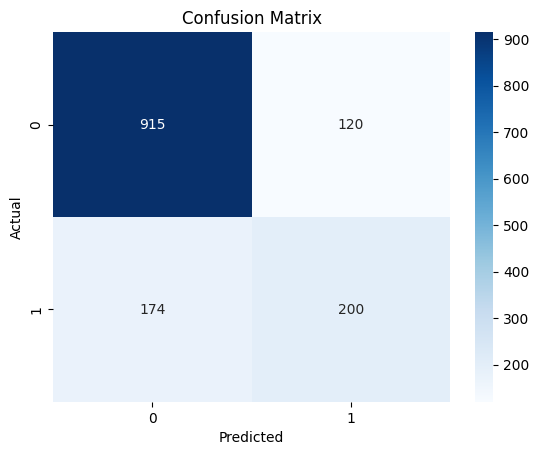

In [7]:
model.fit(X_train_sel, y_train_proc)
evaluate_classification_model(model, X_test_sel, y_test_proc)
plot_confusion(model, X_test_sel, y_test_proc)

# Plot feature importance (if model supports it)


In [8]:
if hasattr(model, 'feature_importances_'):
    import numpy as np
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
    plt.title("Feature Importances")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.show()

# Show Optuna best trial graph (if tuning was used)


In [9]:
if config.get('do_tuning', False):
    import optuna.visualization as vis
    from optuna.visualization import plot_optimization_history

    print("\n Optuna Optimization History:")
    study = results['model_selector'].study if hasattr(results['model_selector'], 'study') else None
    if study:
        fig = plot_optimization_history(study)
        fig.show()
    else:
        print("No Optuna study object available.")